# Fusing animal images using deep learning


### Author:  Elsa Scola Martín

### Objective:

-  Design and implement a deep learning approach to create a “chimera”.


### What is done in the Notebook: 
- Download the data
- Preprocess and Visualize the data
- Build a Generative Adversarial Network
    - Function to create the Tensorflow placeholders
    - Discriminator function
    - Image generator function
    - Model loss function
    - Model optimization function
- Train the neural network
    - Function to show the output of the generator
    - Train function
    - Training
- Analysis of the results

# Generative Adversarial Networks

In this approach my goal is to use GANs to generate images of __people mixed with dogs__. Nevertheless, before that I will ensure the neural network works properly by following the next steps:

- Test the neural network on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This data is simpler, which will allow me to see how well my model trains sooner.
- Test the neural network on the [CelebA dataset](https://www.kaggle.com/jessicali9530/celeba-dataset). As I'm going to be mixing people's faces with dog's faces, I will be testing the neural network with the Celebrity dataset first, which is more complex than the MNIST dataset, and I will obtain more concrete results on how is the performance of my neural network with people's faces.
- Once I've done the previous tests, I'm sure that neural network works properly, and therefore, I can test it with the PersonDog dataset, which is a dataset that I have created by mixing the CelebA dataset with the [Flickr Dog dataset](http://www.recod.ic.unicamp.br/~rwerneck/datasets/flickr-dog/), and the pictures of dogs from the [LHI-Animal-Faces dataset](http://www.stat.ucla.edu/~zzsi/HiT/exp5.html).

I've chosen to mix people and dog faces as there wasn't any animal face dataset that was big enough to obtain nice images, and my results with the celebrity dataset were pretty good.

NOTE: This notebook is not meant to be executed in a continuous way, this means it is not recommended to run it all at once. Many sections are divided in _MNIST_, _CelebA_ and _Person + Dog_, therefore, it is convinient to execute only de code parts that you are interested in. This is done this way not to repeat the same code through all the notebook.

## Download the data

As the data I'm using is quite big, I use this _helper.py_ file that functions as a wrapper and enables to download the data from my hosting service from any computer without needing to pass the whole dataset by email or cloud services, it just makes it easier.

If you are curious about what/how each function works in _helper.py_, there are comments all over the file.

In [1]:
# This is the folder where the input data will be located, 
# if the data already exists in that folder, it will take it from there,
# otherwhise it will download it in that folder.
data_dir = './input'

# Import the helper file
import helper



Fist of all, we check if there is any data in the _input_ folder , and if there isn't we download it.

### MNIST

In [2]:
helper.download_extract('mnist', data_dir)

Found mnist Data


### CelebA

In [2]:
helper.download_extract('celeba', data_dir)

Found celeba Data


### Person + Dog

In [2]:
helper.download_extract('personDog', data_dir)


Found personDog Data


## Preprocess and Visualize the Data

The values of the MNIST, CelebA and PersonDog datasets will be in the range of -0.5 to 0.5 of 28x28 dimensional images. The CelebA and PersonDog dataset images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28. See the method *get_image* from _helper.py_.

The MNIST images are black and white images with a **single color channel**, while the CelebA and PersonDog images have **3 color channels** (RGB color channel).

In this case I use the helper file to show a preview of the dataset I'm working with. This often helps to imagine what kind of results you are looking for. It is displayed on a 5 x 5 grid, which is the way I'll be displaying the results through all the notebook. 

### MNIST
The MNIST dataset contains images of handwritten digits. The goal is to generate new digits that look like the real ones.

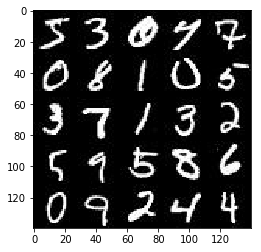

In [3]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The CelebA dataset contains over 200,000 celebrity images with annotations.  Since I'm going to be generating faces, I won't need the annotations. 
I show a preview of the dataset as in the previous examples.

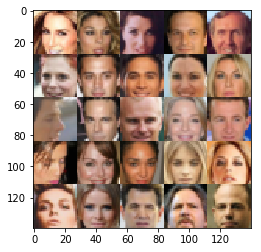

In [3]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

# I'm using the same name (mnist_images) so I can use the same functions
# without repeating the whole code
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

### Person + Dog

The PersonDog dataset is a "self made" dataset containing celebrity images and dog faces. As in the previous examples, I show a little preview of the datset.

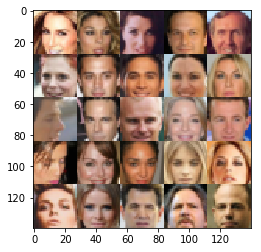

In [3]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

# I'm using the same name (mnist_images) so I can use the same functions
# without repeating the whole code
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'personDog/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Build the Neural Network
These are the necessary components to build a GAN:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

In [12]:
import tensorflow as tf

### Input
The `model_inputs` function creates Tensorflow Placeholders for the Neural Network. 

It creates the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

In [13]:

# The model inputs
# image_width: The input image width
# image_height: The input image height
# image_channels: The number of image channels
# z_dim: The dimension of Z
# return: Tuple of (tensor of real input images, tensor of z data, learning rate)


def model_inputs(image_width, image_height, image_channels, z_dim):
   
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z") 
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate


### Discriminator
`discriminator` creates a discriminator neural network that discriminates on `images`.  This function is able to reuse the variabes in the neural network, by using [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused. The function returns the tensor output of the generator and the tensor logits of the generator.

In [14]:

# Create the discriminator network
# image: Tensor of input image(s)
# reuse: Boolean if the weights should be reused
# return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)


def discriminator(images, reuse=False):

    alpha = 0.2
        
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Start conv stack
        
        # Input layer shape 28x28x3 
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) # relu1.shape: 14x14x64
                
                
        # Second convolution layer
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2) # relu2.shape: 7x7x128
                
        # Third convolution layer
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)  # relu3.shape: 4x4x256
              
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                              
        return out, logits


### Generator
`generator` generates an image using `z`. This function is able to reuse the variabes in the neural network by using  [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function returns the generated 28 x 28 x `out_channel_dim` images.

In [15]:
from IPython.core.debugger import set_trace

# Create the generator network
# z: Input z
# out_channel_dim: The number of channels in the output image
# is_train: Boolean if generator is being used for training
# return: The tensor output of the generator

def generator(z, out_channel_dim, is_train=True):
    
    
    alpha = 0.2
             
    with tf.variable_scope('generator', reuse=not is_train):
        
        # reuse = not is_train because we want to reuse the parameters when we are generating 
        # the samples. Nevertheless, that will not occur during the training. 
        # Initially the generator will start off by training and not by generating images,
        # therefore, the value of is_train in that case should be True.
        
           
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
                
        # Reshape and start deconv stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) # shape: 7x7x256
   
        # Second convolution layer
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')   
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2) # shape 14x14x128
        
        # Third convolution layer    
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3) # shape: 28x28x64
        
        # Dropout
        drop = tf.nn.dropout(x3, keep_prob=0.5)
               
        # Output layer
        logits = tf.layers.conv2d_transpose(drop, out_channel_dim, 5, strides=1, padding='same')
                                           
        out = tf.tanh(logits)
            
        return out
       

### Loss
`model_loss` builds the GANs for training and calculate the loss. The function returns the discriminator loss and the generator loss by using the previously implemented functions:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
# Get the loss for the discriminator and generator
# input_real: Images from the real dataset
# input_z: Z input
# out_channel_dim: The number of channels in the output image
# return: A tuple of (discriminator loss, generator loss)

def model_loss(input_real, input_z, out_channel_dim):
   
    smooth = 0.1 # label smoothing
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss
    

### Optimization
`model_opt` creates the optimization operations for the GANs by using [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables. It filters the variables with names that are in the discriminator and generator scope names. The function returns the discriminator training operation and the generator training operation.

In [17]:
# Get optimization operations
# d_loss: Discriminator loss Tensor
# g_loss: Generator loss Tensor
# learning_rate: Learning Rate Placeholder
# beta1: The exponential decay rate for the 1st moment in the optimizer
# return: A tuple of (discriminator training operation, generator training operation)
    
def model_opt(d_loss, g_loss, learning_rate, beta1):
      
    # Get weights and bias to update
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


## Neural Network Training
### Show Output
This function shows the current output of the generator during training. It has helped me determine how well the GANs is training.

In [18]:
import numpy as np

# Show example output for the generator
# sess: TensorFlow session
# n_images: Number of Images to display
# input_z: Input Z Tensor
# out_channel_dim: The number of channels in the output image
# image_mode: The mode to use for images ("RGB" or "L")

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
`train` builds and trains the GANs.  It uses the following functions previously implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

`show_generator_output` shows the `generator` output while training. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook. The `generator` output is printed every 100 batches, because running `show_generator_output` for every batch would drastically increase training time, as well as the size of the notebook.

In [19]:
# Train the GAN
# epoch_count: Number of epochs
# batch_size: Batch Size
# z_dim: Z dimension
# learning_rate: Learning Rate
# beta1: The exponential decay rate for the 1st moment in the optimizer
# get_batches: Function to get batches
# data_shape: Shape of the data
# data_image_mode: The image mode to use for images ("RGB" or "L")

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    print_every=10 
    show_every=100
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                                
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Normalize the inputs
                batch_images *= 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST

Epoch 1/2... Discriminator Loss: 2.6336... Generator Loss: 1.4100
Epoch 1/2... Discriminator Loss: 2.0696... Generator Loss: 5.3323
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 2.2653
Epoch 1/2... Discriminator Loss: 1.6711... Generator Loss: 2.6983
Epoch 1/2... Discriminator Loss: 1.6412... Generator Loss: 1.8665
Epoch 1/2... Discriminator Loss: 1.7966... Generator Loss: 1.9795
Epoch 1/2... Discriminator Loss: 1.7835... Generator Loss: 2.4734
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 1.3622
Epoch 1/2... Discriminator Loss: 1.7463... Generator Loss: 2.6283
Epoch 1/2... Discriminator Loss: 1.4404... Generator Loss: 2.3622


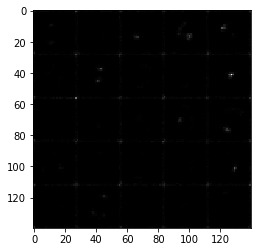

Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 1.9070
Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 1.7189
Epoch 1/2... Discriminator Loss: 1.1732... Generator Loss: 1.2065
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 2.1925
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 2.3539
Epoch 1/2... Discriminator Loss: 1.6533... Generator Loss: 2.4810
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 1.0733
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 1.7694
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 2.0055
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 1.6020


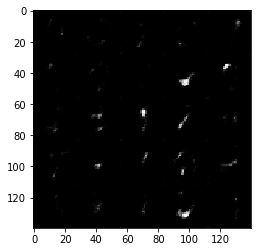

Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 1.4505
Epoch 1/2... Discriminator Loss: 1.5204... Generator Loss: 0.5440
Epoch 1/2... Discriminator Loss: 1.8565... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 0.5205
Epoch 1/2... Discriminator Loss: 1.2596... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 1.4902
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 1.2849
Epoch 1/2... Discriminator Loss: 1.6417... Generator Loss: 2.0382
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.6673
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.6269


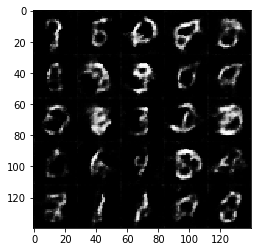

Epoch 1/2... Discriminator Loss: 1.6825... Generator Loss: 0.3629
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.5712
Epoch 1/2... Discriminator Loss: 1.5154... Generator Loss: 0.4540
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 1.5774
Epoch 1/2... Discriminator Loss: 1.4983... Generator Loss: 0.4701
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.4533... Generator Loss: 1.8282
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 0.7916
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.5980


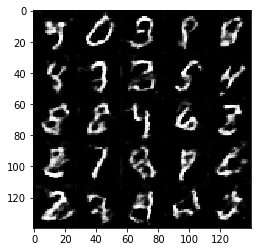

Epoch 1/2... Discriminator Loss: 1.5697... Generator Loss: 0.4253
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.6303
Epoch 1/2... Discriminator Loss: 1.3486... Generator Loss: 0.5895
Epoch 1/2... Discriminator Loss: 1.6128... Generator Loss: 0.3836
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 1.1179
Epoch 1/2... Discriminator Loss: 1.2662... Generator Loss: 0.8695
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 0.4951
Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 0.5139
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 0.5692
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.4484


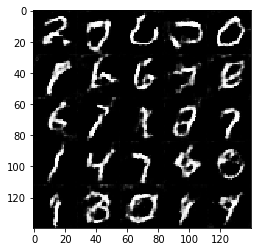

Epoch 1/2... Discriminator Loss: 1.7088... Generator Loss: 0.3503
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.5945
Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.7063
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 1.0027
Epoch 1/2... Discriminator Loss: 1.7539... Generator Loss: 0.3675
Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 0.4894
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 1.5841
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 0.9589
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 1.9766


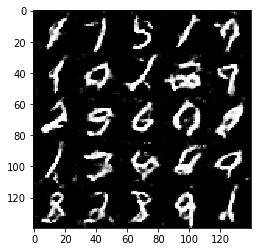

Epoch 1/2... Discriminator Loss: 2.0331... Generator Loss: 2.3880
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 1.1026
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.5015
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 1.2084
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 1.1986
Epoch 1/2... Discriminator Loss: 1.2365... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.7076... Generator Loss: 0.3576


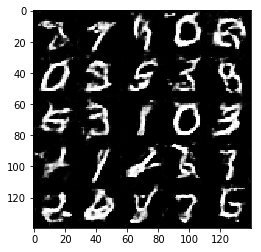

Epoch 1/2... Discriminator Loss: 1.5435... Generator Loss: 0.4899
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 1.4738
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 1.6931
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 1.7467
Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 1.4259
Epoch 1/2... Discriminator Loss: 1.5999... Generator Loss: 1.4864
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 1.0134
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 1.2083
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.8480


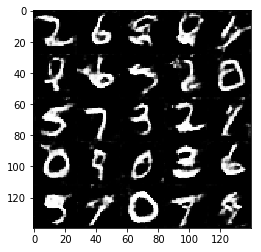

Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 1.6089
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 1.2467
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 1.2487
Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 2.2700
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 0.7340
Epoch 1/2... Discriminator Loss: 1.8674... Generator Loss: 0.2777
Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 1.0266
Epoch 1/2... Discriminator Loss: 1.0308... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 0.9538
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 1.4182


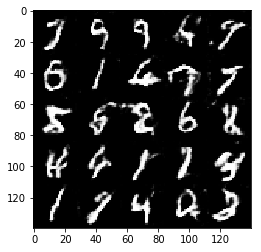

Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.8583
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 1.5333
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 1.6643
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 1.2590
Epoch 2/2... Discriminator Loss: 1.0128... Generator Loss: 1.5098
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 0.9496
Epoch 2/2... Discriminator Loss: 1.5967... Generator Loss: 0.4857
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 1.7322... Generator Loss: 0.3927


Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 1.1155... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.0641... Generator Loss: 0.8859
Epoch 2/2... Discriminator Loss: 1.5618... Generator Loss: 1.6212
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 1.1734
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 2.0886
Epoch 2/2... Discriminator Loss: 1.5493... Generator Loss: 0.4040
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 2.7360
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 1.1104


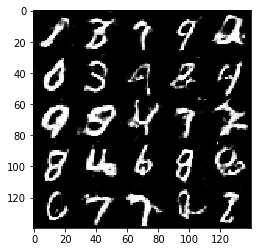

Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 1.9686
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 0.9897
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 1.7369
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.4735... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 2.3698
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 1.5562
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 1.1312
Epoch 2/2... Discriminator Loss: 1.4475... Generator Loss: 2.6347
Epoch 2/2... Discriminator Loss: 1.1072... Generator Loss: 0.8907


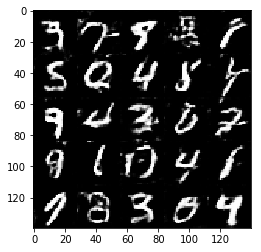

Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 2.2956
Epoch 2/2... Discriminator Loss: 1.2077... Generator Loss: 1.8579
Epoch 2/2... Discriminator Loss: 1.1282... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 0.8198
Epoch 2/2... Discriminator Loss: 1.8891... Generator Loss: 3.0377
Epoch 2/2... Discriminator Loss: 1.0842... Generator Loss: 1.1158
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 1.7502
Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 1.1284... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 2.2344


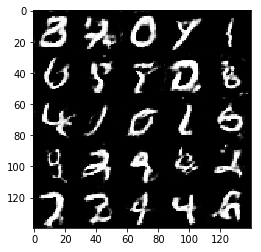

Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 1.1758
Epoch 2/2... Discriminator Loss: 2.3113... Generator Loss: 0.2594
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 1.4220
Epoch 2/2... Discriminator Loss: 0.9173... Generator Loss: 1.1864
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 1.2755
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 1.1744
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.8335
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 0.8252
Epoch 2/2... Discriminator Loss: 1.1846... Generator Loss: 0.7319


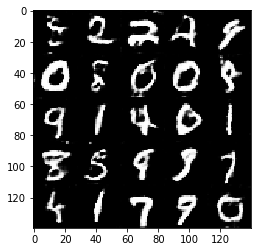

Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.1732
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.5239
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.6141
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.8214
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 0.9824
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 1.3237


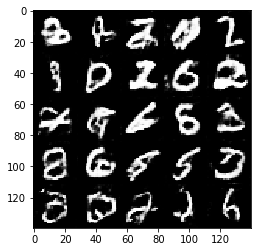

Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.4389
Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 1.3883
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 2.9217
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 1.4698
Epoch 2/2... Discriminator Loss: 1.1730... Generator Loss: 0.8093
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 1.3248
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 1.2191
Epoch 2/2... Discriminator Loss: 1.5180... Generator Loss: 3.0281
Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 0.7188
Epoch 2/2... Discriminator Loss: 1.4380... Generator Loss: 0.4783


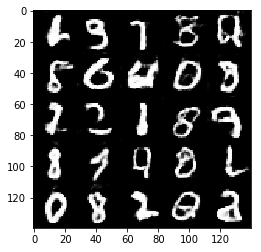

Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.4596
Epoch 2/2... Discriminator Loss: 1.9947... Generator Loss: 3.9229
Epoch 2/2... Discriminator Loss: 1.2049... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.7019
Epoch 2/2... Discriminator Loss: 2.5707... Generator Loss: 3.6824
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 2.3197
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 0.8810
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 1.9418
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 1.2662
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.3711


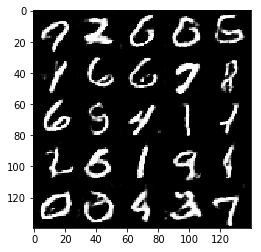

Epoch 2/2... Discriminator Loss: 0.9852... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.7038... Generator Loss: 2.4951
Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 1.2288
Epoch 2/2... Discriminator Loss: 0.7794... Generator Loss: 1.5215
Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 2.3703
Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 0.8592
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 1.2049... Generator Loss: 1.0506


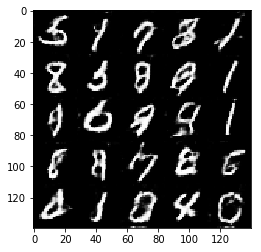

Epoch 2/2... Discriminator Loss: 1.1336... Generator Loss: 0.9170
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.8792
Epoch 2/2... Discriminator Loss: 1.0401... Generator Loss: 0.8737
Epoch 2/2... Discriminator Loss: 1.7423... Generator Loss: 0.4671
Epoch 2/2... Discriminator Loss: 1.0814... Generator Loss: 1.0607
Epoch 2/2... Discriminator Loss: 0.8545... Generator Loss: 1.7319
Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 1.3276


In [12]:
batch_size = 64 # worse with 32 and greater lr
z_dim = 100
learning_rate = 0.002 # worse with greater lr
beta1 = 0.3

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA

Epoch 1/1... Discriminator Loss: 2.2960... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 2.3663... Generator Loss: 0.1992
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 1.6670
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 3.7273
Epoch 1/1... Discriminator Loss: 1.7387... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.4937
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 1.7300
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 2.4367... Generator Loss: 0.1834
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.9672


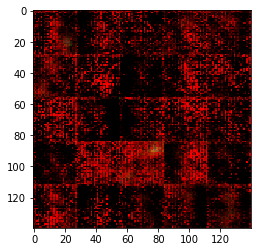

Epoch 1/1... Discriminator Loss: 1.8978... Generator Loss: 1.6478
Epoch 1/1... Discriminator Loss: 1.7850... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.9113... Generator Loss: 0.2855
Epoch 1/1... Discriminator Loss: 2.1045... Generator Loss: 2.8014
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 2.8905
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.8326... Generator Loss: 0.4477
Epoch 1/1... Discriminator Loss: 2.1245... Generator Loss: 0.2162
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8990


Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 1.8004
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 2.1475... Generator Loss: 2.1901
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.8726... Generator Loss: 1.9983
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 1.4398


Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 1.3900
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.6248... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.6157


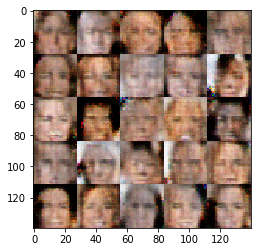

Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.4133
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.0694


Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7563


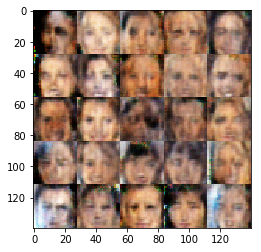

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7905


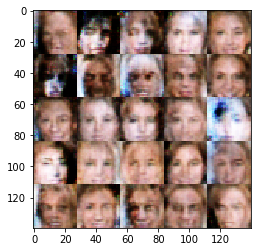

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8353


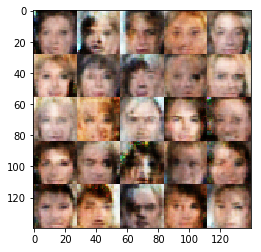

Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.9038


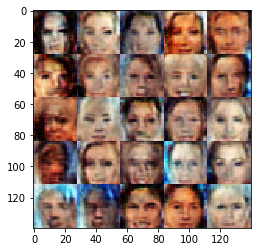

Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7270


Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8433


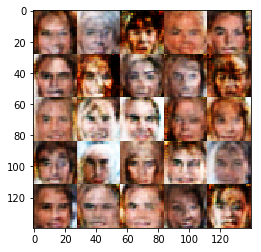

Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8434


Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 1.0454


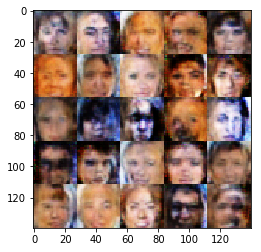

Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7894


Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8813


Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6429


Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7760


Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8142


Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.9000


Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7382


Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7439


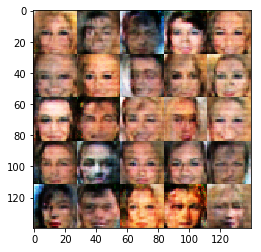

Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7587


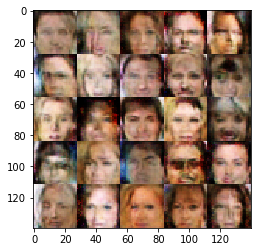

Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.8831


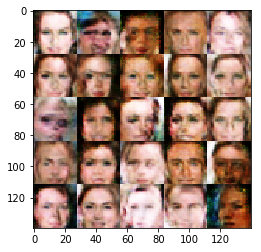

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 1.0403


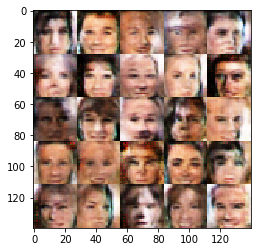

Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7023


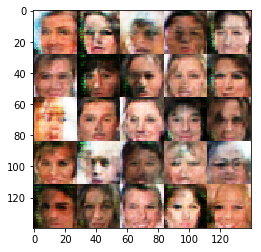

Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.7884


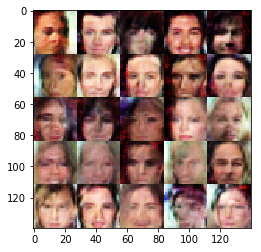

Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 1.3320
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6827


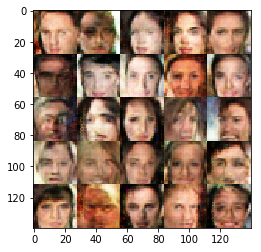

Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.8139


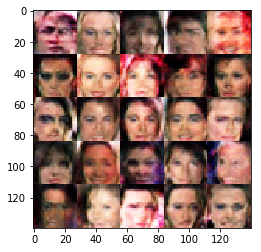

Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8215


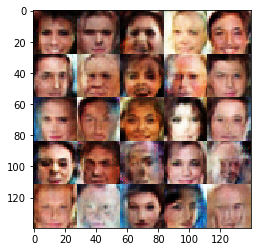

Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6846


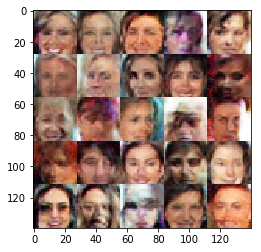

Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7321


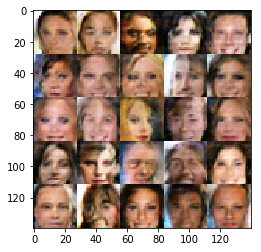

Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7706


In [20]:
batch_size = 64 # worse with 32 and greater lr
z_dim = 100
learning_rate = 0.002 # worse with greater lr
beta1 = 0.3


epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Person + Dog

Epoch 1/2... Discriminator Loss: 6.0379... Generator Loss: 0.0172
Epoch 1/2... Discriminator Loss: 1.9442... Generator Loss: 1.8687
Epoch 1/2... Discriminator Loss: 1.6415... Generator Loss: 0.4638
Epoch 1/2... Discriminator Loss: 2.9205... Generator Loss: 3.6560
Epoch 1/2... Discriminator Loss: 2.2951... Generator Loss: 0.2958
Epoch 1/2... Discriminator Loss: 1.9239... Generator Loss: 6.0345
Epoch 1/2... Discriminator Loss: 0.4224... Generator Loss: 3.2963
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 1.7096
Epoch 1/2... Discriminator Loss: 4.3001... Generator Loss: 6.3736
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.7333


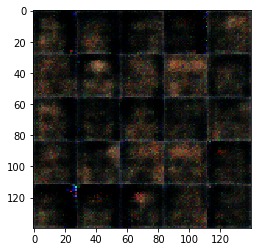

Epoch 1/2... Discriminator Loss: 2.2405... Generator Loss: 0.3989
Epoch 1/2... Discriminator Loss: 1.2066... Generator Loss: 1.1745
Epoch 1/2... Discriminator Loss: 1.5808... Generator Loss: 0.5463
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.8458
Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 0.8523
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.1715... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 2.0904... Generator Loss: 0.2122
Epoch 1/2... Discriminator Loss: 1.5657... Generator Loss: 0.4182


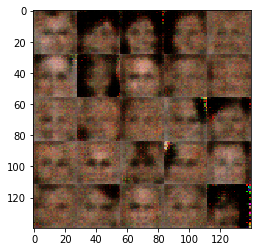

Epoch 1/2... Discriminator Loss: 1.9692... Generator Loss: 0.3447
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.8669
Epoch 1/2... Discriminator Loss: 1.9546... Generator Loss: 2.2062
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.8044... Generator Loss: 0.3407
Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 1.6119
Epoch 1/2... Discriminator Loss: 1.2164... Generator Loss: 1.1889
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 1.3168... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 2.4134... Generator Loss: 2.2890


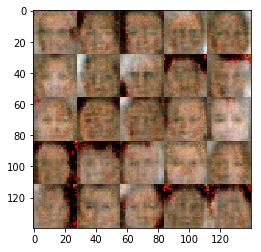

Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.4805... Generator Loss: 0.9117
Epoch 1/2... Discriminator Loss: 1.4394... Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.9687
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 0.5956
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.6104


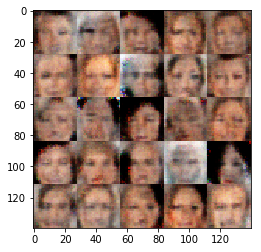

Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.8709
Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.6392
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.5564
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 1.0126
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 1.1578
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 0.8828


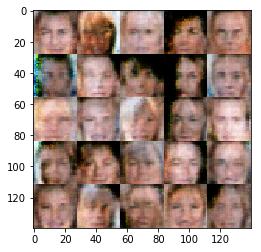

Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 0.5417
Epoch 1/2... Discriminator Loss: 1.3400... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 1.0302
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 1.0476
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.9087
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 1.0218


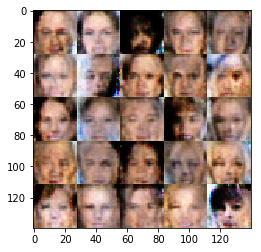

Epoch 1/2... Discriminator Loss: 1.4184... Generator Loss: 0.6705
Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.5258
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 0.4939
Epoch 1/2... Discriminator Loss: 1.3647... Generator Loss: 0.8808
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.7204
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.8706


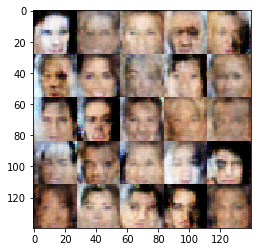

Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 1.0370
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 0.8765
Epoch 1/2... Discriminator Loss: 1.6559... Generator Loss: 1.1473
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.9569
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.7771


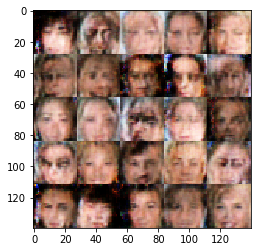

Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.7913
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.7192
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.8469
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 0.7474
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.7973


Epoch 1/2... Discriminator Loss: 1.4181... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.9508
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.8498


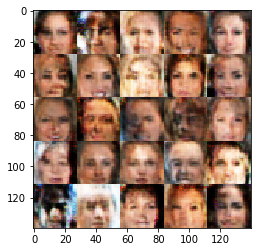

Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 1.5435... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.4042... Generator Loss: 1.0024
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.4084... Generator Loss: 0.9892
Epoch 1/2... Discriminator Loss: 1.4587... Generator Loss: 0.9799
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 0.8825
Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.7888


Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.8796
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.7204
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 1.4459... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.6567
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 0.7317
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.7661


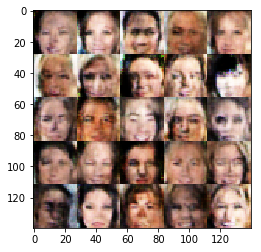

Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.6997
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.9693
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.7389
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 0.8238


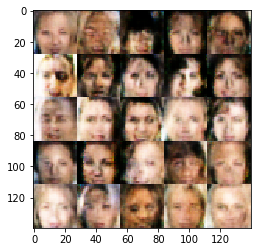

Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.7167
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 0.7207
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.7096
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 1.0060
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.8484
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.8561


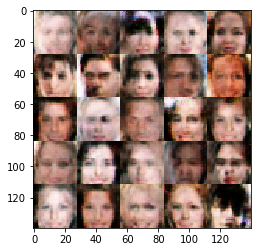

Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.8100
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.7077
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.6159
Epoch 2/2... Discriminator Loss: 1.6868... Generator Loss: 1.8716


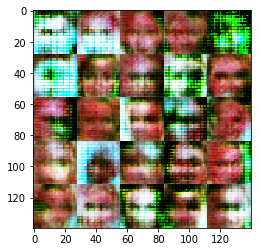

Epoch 2/2... Discriminator Loss: 1.5116... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 1.3560... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 0.7482
Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 0.7291
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.8437
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.4713... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7940
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 0.7240


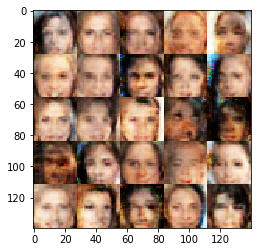

Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.8506
Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.6832
Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.6948
Epoch 2/2... Discriminator Loss: 1.3507... Generator Loss: 0.7583
Epoch 2/2... Discriminator Loss: 1.4139... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.8912
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.8961
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.7482
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.8505


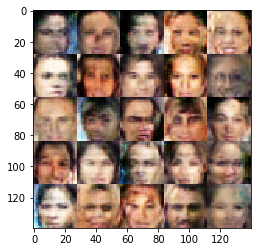

Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.7570
Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.7847
Epoch 2/2... Discriminator Loss: 1.3778... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 1.3245... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 0.7070
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.4149... Generator Loss: 0.8444
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.7785


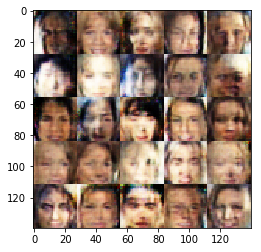

Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.8408
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 0.9060
Epoch 2/2... Discriminator Loss: 1.4072... Generator Loss: 0.6838
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.8191
Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 0.8229


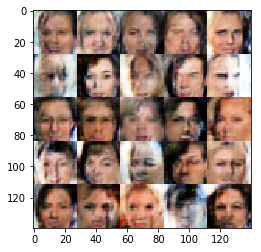

Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 0.6317
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.7426
Epoch 2/2... Discriminator Loss: 1.3903... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.8144
Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 0.8722
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 0.6916


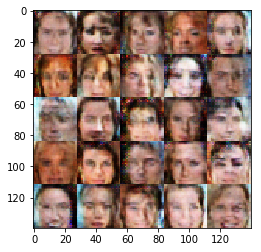

Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.6972
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.6575
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 0.9353
Epoch 2/2... Discriminator Loss: 1.4132... Generator Loss: 0.8933
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.8700
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 0.6266
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.7205


Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.8563
Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.8951
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.9478
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.4226... Generator Loss: 0.8720
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.7854
Epoch 2/2... Discriminator Loss: 1.3216... Generator Loss: 0.8679


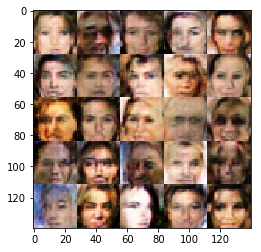

Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 0.7223
Epoch 2/2... Discriminator Loss: 1.3889... Generator Loss: 0.9361
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.7182
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.9359
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.8504
Epoch 2/2... Discriminator Loss: 1.3355... Generator Loss: 0.7483
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.8816
Epoch 2/2... Discriminator Loss: 1.3727... Generator Loss: 0.7901


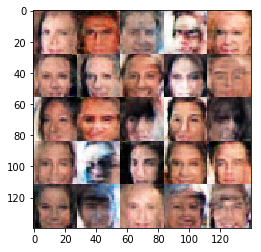

Epoch 2/2... Discriminator Loss: 1.3245... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.3665... Generator Loss: 0.9128
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.8556
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.7684
Epoch 2/2... Discriminator Loss: 1.3292... Generator Loss: 0.7617
Epoch 2/2... Discriminator Loss: 1.3084... Generator Loss: 0.8007
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.7206


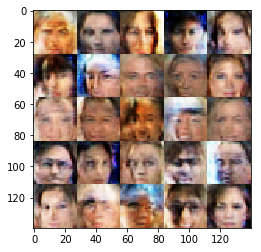

Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.6577
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.3419... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 1.1164
Epoch 2/2... Discriminator Loss: 1.3761... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.2780... Generator Loss: 0.8040


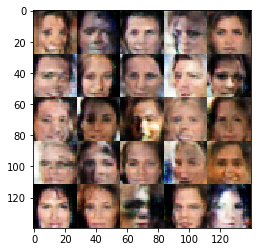

Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.6840
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.7454
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.8276
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.8687
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.9678
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.6189


Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.7701
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.6661
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 1.0019
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.7360
Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 0.9076
Epoch 2/2... Discriminator Loss: 1.4007... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.8373


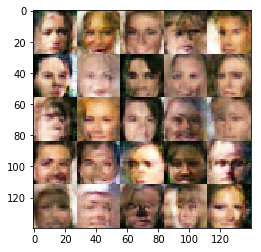

Epoch 2/2... Discriminator Loss: 1.5536... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.7937
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 1.3428... Generator Loss: 0.6674
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.7586
Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 1.1116
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.9993
Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.8556


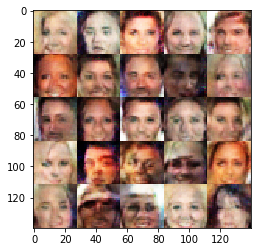

Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.8682
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.6486
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 0.7571
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.7483
Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 0.9781
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.8101
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 0.7378
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.7318
Epoch 2/2... Discriminator Loss: 1.4640... Generator Loss: 0.8463


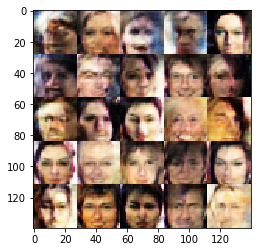

Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.8686
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.8584
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 0.6127
Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.9228


In [12]:
batch_size = 64 # worse with 32 and greater lr
z_dim = 100
learning_rate = 0.002 # worse with greater lr
beta1 = 0.3


epochs = 2

# The process is the same as the CelebA
mnist_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'personDog/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## Analysis of the results
Analysing the three results from the three trials of the Generative Adversarial Network, we can see that the neural network much better when there is a consistent dataset. Meaning by consistent, that the data mantains a similar format. It also helps a lot for the training, to have a big dataset, because smaller ones don't give the network the appropriate time to train, and therefore, the results are poor. 

The PersonDog dataset has less than 800 dog faces and over 200.000 person faces. Obviously, there isn't enough dog data, but I have prioritized quality versus quantity after doing several trials with much bigger datasets, where the majority of the images had a lot of noise, and where it didn't only appear the dog's face, but also its body and the environment (usually with many other elements in it). This situation accurs for other animal dataset too, and for this reason, I've chosen to mix this small "good quality" dataset with a big and consistent dataset, which is the Celebrity dataset.

The results could definitely be improved, by creating a consistent dataset of dog faces, which had only one specie's data, because the changes between the different species make the data more inconsistent, and therefore the results are worse.

Nevertheless, the results are pretty decent. In the following images I will show my favourite Chimeras results:


![title](img/faces.png)

Regarding the standard loss function, we can also appreciate that the quality of generated images does not correlate with the loss of either the generator or the discriminator. Since both are competing against each other, the losses fluctuate. For future major improvements here is an [article](https://arxiv.org/abs/1701.07875) that explains how GANs have always had problems with convergence and, as a consequence, there is no way to know when to stop training them. In other words, the loss function doesn’t correlate with image quality. 

This is a big problem because:
- you need to be constantly looking at the samples to tell whether you model is training correctly or not.
- you don’t know when to stop training (no convergence).
- you don’t have a numerical value that tells you how well are you tuning the parameters.

This interpretability issue is one of the problems that Wasserstein GANs aims to solve. 